# Primary model experiments

This notebook intends to test the models specified in the file `preliminary_model.pdf` to estimate prevalence. 

In [53]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm.notebook import tqdm

import sys  
sys.path.insert(0, '../../scripts/')

from artificial_data import GenerateData

## Notebook settings

In [54]:
sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Perfect tests

In [4]:
#compiled = False
compiled = True

In [5]:
if compiled: 
    sm = pickle.load(open('pickles/perfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/perfect_test.stan')
    with open('pickles/perfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

First we describe data created artificially. First we create the covariate variables to use in all models. 

In [6]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors), 
                           cov = np.eye(n_predictors),
                           size = n_samples) 

And now we first generate the data considering the model. 

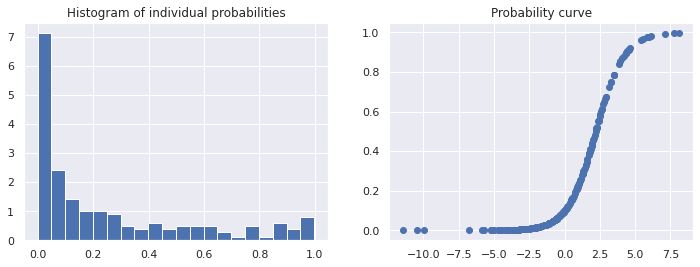

In [7]:
beta = np.array([0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1
theta = expit(logit(prevalence) + x@beta)

T = ro.binomial(n = 1, p = theta)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(theta, density = True, bins = 20)
ax[1].scatter(x@beta, theta)
ax[0].set_title('Histogram of individual probabilities')
ax[1].set_title('Probability curve')

plt.show()

In [8]:
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
}

T.mean()

0.275

Now we describe the necessary pieces to the model. 

In [9]:
Sigma   = np.eye(5)
mu      = np.zeros(5)
alpha_p = 1
beta_p  = 3

data.update({
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p
})

And we apply it to the sampling.

In [10]:
fit_perfect = sm.sampling(data=data, iter=5000)

In [11]:
print(fit_perfect)

Inference for Stan model: anon_model_9b98d602c1db1bbe30bbb5b0245fea83.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

                    mean se_mean     sd   2.5%     25%    50%    75%  97.5%  n_eff   Rhat
effects[1]          0.15  2.1e-3   0.23   -0.3 -2.6e-3   0.15   0.31   0.62  11765    1.0
effects[2]          2.38  4.1e-3   0.36   1.71    2.14   2.38   2.62   3.12   7667    1.0
effects[3]         -0.91  2.4e-3   0.24  -1.39   -1.07   -0.9  -0.75  -0.46   9662    1.0
effects[4]           1.6  3.4e-3   0.29   1.06     1.4   1.59   1.79   2.19   7104    1.0
effects[5]          0.22  2.3e-3   0.24  -0.26    0.05   0.21   0.38    0.7  11180    1.0
prev                0.11  3.6e-4   0.03   0.06    0.09   0.11   0.13   0.18   6563    1.0
effects_prior[1] -3.1e-4 10.0e-3   1.01  -1.99   -0.68 3.5e-3   0.68   1.96  10151    1.0
effects_prior[2] -3.5e-3    0.01    1.0  -1.97   -0.66 5.4e-3   0.66   1.94   9815    1.0


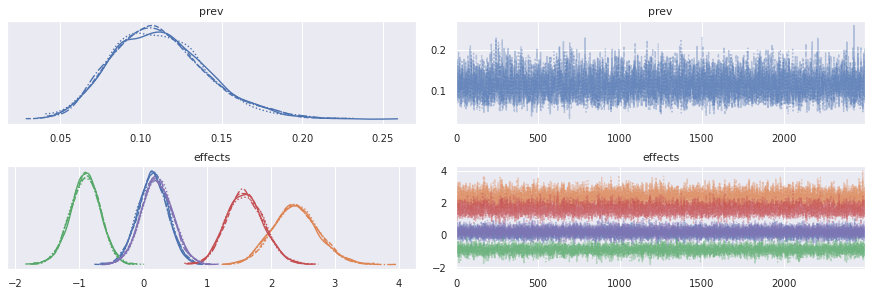

In [12]:
az.plot_trace(fit_perfect, var_names=('prev', 'effects'))
plt.show()

### Practical identifiability

Varying $\beta_1$ value (the intercept) with prevalence fixed. 

In [13]:
x_test = ro.multivariate_normal(mean = np.zeros(1), 
                                cov = np.eye(1),
                                size = 100) 

data_test = {
    "n_samples"    : 100,
    "n_predictors" : 1,
    "x"            : x_test,  
    "Sigma"        : np.eye(1), 
    "mu"           : np.zeros(1),
    "alpha_p"      : 1, 
    "beta_p"       : 3,
    "T"            : 0
}

values = []

for each in tqdm(range(100)): 
    
    beta_test = ro.uniform(-2,2, size=(1,1))
    theta = expit(logit(prevalence) + x_test@beta_test)
    T = ro.binomial(n = 1, p = theta)
    
    data_test.update({
        "T"            : T.flatten(),
    })

    fit_test = sm.sampling(data=data_test) 
    prev_estimated = fit_test.extract()['prev'].mean()
        
    values.append((beta_test[0,0], prev_estimated))
    
values = np.array(values)

  0%|          | 0/100 [00:00<?, ?it/s]

Correlation: -0.05056132711130287


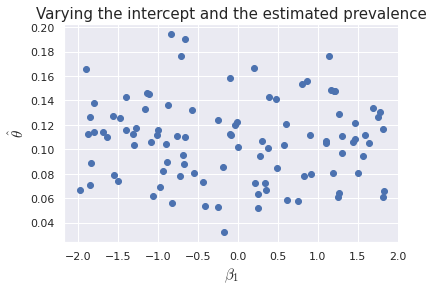

In [14]:
plt.scatter(values[:,0], values[:,1])
print("Correlation: {}".format(np.corrcoef(values[:,0], values[:,1])[0,1]))
plt.xlabel(r'$\beta_1$', fontsize = 15)
plt.ylabel(r'$\hat{\theta}$', fontsize = 15)
plt.title('Varying the intercept and the estimated prevalence', fontsize = 15)
plt.show()

### Priors

Given the priors on the prevalence and on the effects, how it is behaved on the observation-level. 

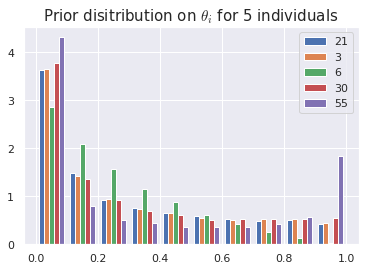

In [15]:
samples = fit_perfect.extract()

ind_prior = expit((logit(samples['prev_prior']) + x@samples['effects_prior'].T))
chosen_individuals = np.random.randint(100,size=5)
plt.hist([ind_prior[i] for i in chosen_individuals], 
         density = True, label = chosen_individuals)
plt.title(r'Prior disitribution on $\theta_i$ for 5 individuals', fontsize = 15)
plt.legend()
plt.show()

## Imperfect tests

Now, we add specificity and sensitivity to the modeling. 

In [16]:
#compiled = False
compiled = True

In [17]:
if compiled: 
    sm = pickle.load(open('pickles/imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/imperfect_test.stan')
    with open('pickles/imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

First we describe data created artificially. 

In [18]:
spec = 0.85
sens = 0.8

theta = expit(logit(prevalence) + x@beta)
p = sens*theta + (1 - spec)*(1 - theta)

T = ro.binomial(n = 1, p = p)

alpha_s = 4
beta_s  = 1
alpha_e = 4
beta_e  = 1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
    
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p,
    "alpha_s"      : alpha_s,
    "beta_s"       : beta_s,
    "alpha_e"      : alpha_e,
    "beta_e"       : beta_e,

}

T.mean()

0.34

And we apply it

In [48]:
fit_imperfect = sm.sampling(data=data, iter=5000)
summary = az.summary(fit_imperfect)

First we observe the relation between $\theta_i$ and $p_i$ among the individuals. 

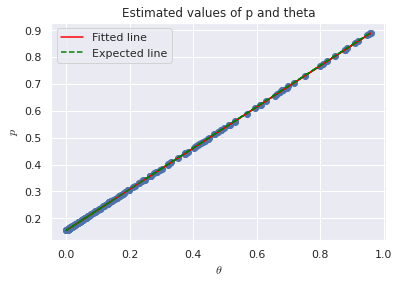

In [88]:
theta_values = summary[summary.index.str.contains('theta')]['mean']
p_values = summary[summary.index.str.contains('p\[')]['mean']

line_parameters = np.polyfit(theta_values, p_values, deg = 1)

spec_hat = summary.loc['spec', 'mean']
sens_hat = summary.loc['sens', 'mean']

plt.scatter(theta_values, p_values)
plt.plot(theta_values, theta_values * line_parameters[0] + line_parameters[1], 
         color = 'red', label = 'Fitted line')
plt.plot(theta_values, theta_values * (spec_hat + sens_hat - 1) + (1 - spec_hat), 
         color = 'green', label = 'Expected line', linestyle = '--')
plt.title('Estimated values of p and theta')
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p$')
plt.legend()
plt.show()

## Imperfect tests + RDS

After considering specificity, a more complex model considering random effect from RDS. 

In [3]:
#compiled = False
compiled = True

In [4]:
if compiled: 
    sm = pickle.load(open('pickles/rds_imperfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/rds_imperfect_test.stan')
    with open('pickles/rds_imperfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data 

Artificial data to use the model. 

In [39]:
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 100, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 20000, 
                                     n_seeds = 3, sample_size = 30, probs = [1/3,1/6,1/6,1/3])

In [40]:
rds_sample.number_of_nodes()

43

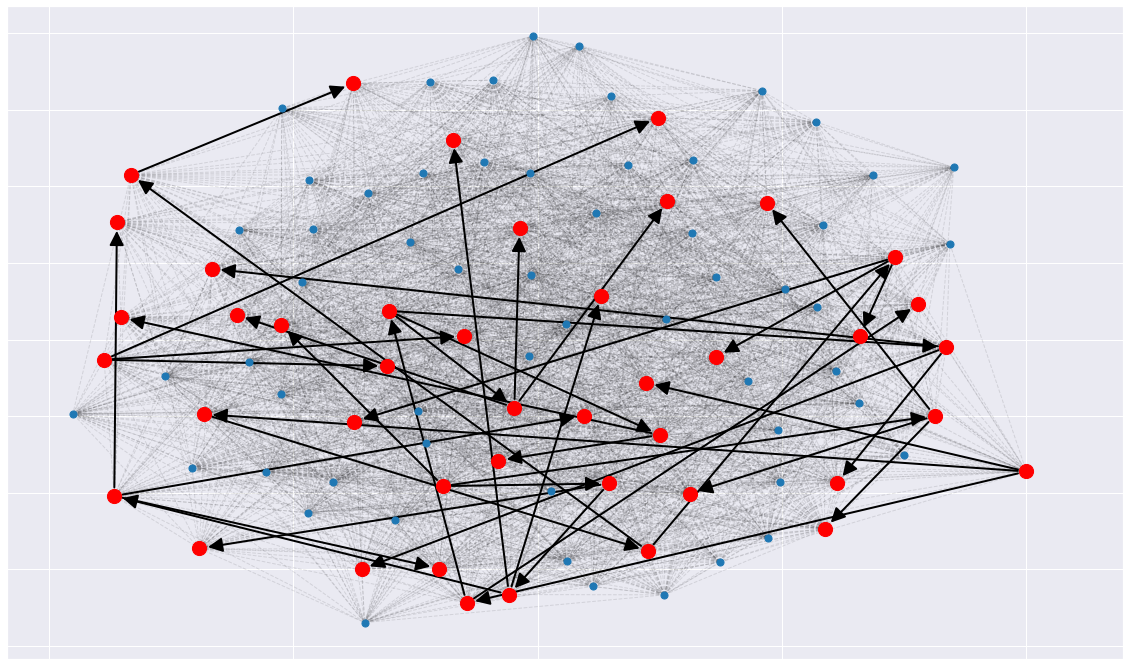

In [41]:
fig, ax = plt.subplots(figsize=(20,12))

pos = nx.spring_layout(graph)

nx.draw_networkx_nodes(graph, pos=pos, node_size = 50, ax = ax)#, node_color = colors, ax = ax)
nx.draw_networkx_edges(graph, pos=pos, edge_color='black', style='dashed',alpha =0.1, ax = ax)

nx.draw_networkx_nodes(rds_sample, pos=pos, node_size = 200, ax = ax, node_color = 'red')
nx.draw_networkx_edges(rds_sample, pos=pos, edge_color='black',alpha =1, width = 2, 
                       arrows = True, arrowsize = 30, ax = ax)
plt.show()

In [47]:
gen_graph = GenerateData()
graph = gen_graph.random_graph(rule = 'erdos-renyi', parameters={'n': 1000, 'p': 0.5, 'seed': 10000})
rds_sample = gen_graph.RDS_generator(graph = graph, seed = 20000, 
                                     n_seeds = 10, sample_size = 200, probs = [1/3,1/6,1/6,1/3])

A = nx.adjacency_matrix(rds_sample)